In [1]:

from example import process_file
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf



from rul_pm.dataset.lives_dataset import AbstractLivesDataset
from rul_pm.iterators.iterators import LifeDatasetIterator
from rul_pm.transformation.transformers import Transformer, transformation_pipeline, numericals_pipeline
from rul_pm.transformation.features.selection import ByNameFeatureSelector
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.transformation.outliers import IQROutlierRemover, ZScoreOutlierRemover
from rul_pm.transformation.imputers import ForwardFillImputer, PandasMeanImputer
from rul_pm.transformation.features.scalers import PandasMinMaxScaler

from rul_pm.transformation.resamplers import ResamplerTransformer
from rul_pm.iterators.iterators import WindowedDatasetIterator, LifeDatasetIterator
from rul_pm.iterators.batcher import get_batcher
from rul_pm.models.keras.simple import FCN

# 1. Dataset

In order to define a dataset you should subclass `AbstractLivesDataset` and define three methods:
    * `__getitem__(self, i)`: This method should return the i-th life 
    * `nlives(self)`: In this method should return the total number of lives present in the dataset

In [2]:
class Dataset(AbstractLivesDataset):
    def __init__(self, file):
        self.lives = [g for _, g in process_file(file).groupby('unit_number')]

    def __getitem__(self, i):
        """

        Returns
        -------
        pd.DataFrame
            DataFrame with the data of the life i
        """
        return self.lives[i]

    @property
    def nlives(self):
        return len(self.lives)

In [3]:
train_dataset = Dataset('train_FD001.txt')
validation_dataset = Dataset('test_FD001.txt')

# 2. Transformers

The transformer class receives 4 parameter:
* The target feature name
* The time feature name
* A pipeline to transform the features
* A pipeline to transform the target

The function transformation_pipeline generates a standard pipeline with steps for outlier removal, missing value imputing, data scaling and resampling.

In [4]:
transformer = Transformer('RUL', 
                  transformerX=transformation_pipeline(
                      numericals_pipeline(
                        numerical_features=[
                              'T24', 'T30', 'T50',  
                               'P15','P30','Nf','Nc', 'Ps30',
                               'phi', 'NRf', 'NRc', 'BPR', 
                               'htBleed', 'W31', 'W32'
                          ],
                          outlier=IQROutlierRemover(1.5, 1), 
                          imputer=ForwardFillImputer(),
                          scaler=PandasTransformerWrapper(RobustScaler()),
                      )))
transformer.fit(train_dataset)

## Iterators

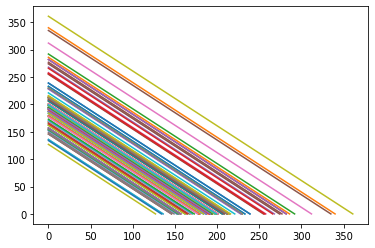

In [5]:
fig, ax = plt.subplots()
it = LifeDatasetIterator(train_dataset, transformer)
for i, (X,y) in enumerate(it):
    ax.plot(y)

## Batcher

The batcher class will return the 

In [7]:
transformer = Transformer('RUL', 
                  transformerX=transformation_pipeline(
                      numericals_pipeline(
                          numerical_features=[
                              'T24', 'T30', 'T50', 
                               'P15','P30','Nf','Nc', 'Ps30',
                               'phi', 'NRf', 'NRc', 'BPR', 
                               'htBleed', 'W31', 'W32'
                          ],
                          outlier=IQROutlierRemover(1.5, 1), 
                          imputer=ForwardFillImputer(),
                          scaler=PandasTransformerWrapper(RobustScaler()),
                      )))
transformer.fit(train_dataset)
window = 25
batch_size = 66
step = 2
train_batcher = get_batcher(train_dataset,  window, batch_size, 
                            transformer, step, shuffle=False)
X, y = next(train_batcher)

### How dos a sample looks like?

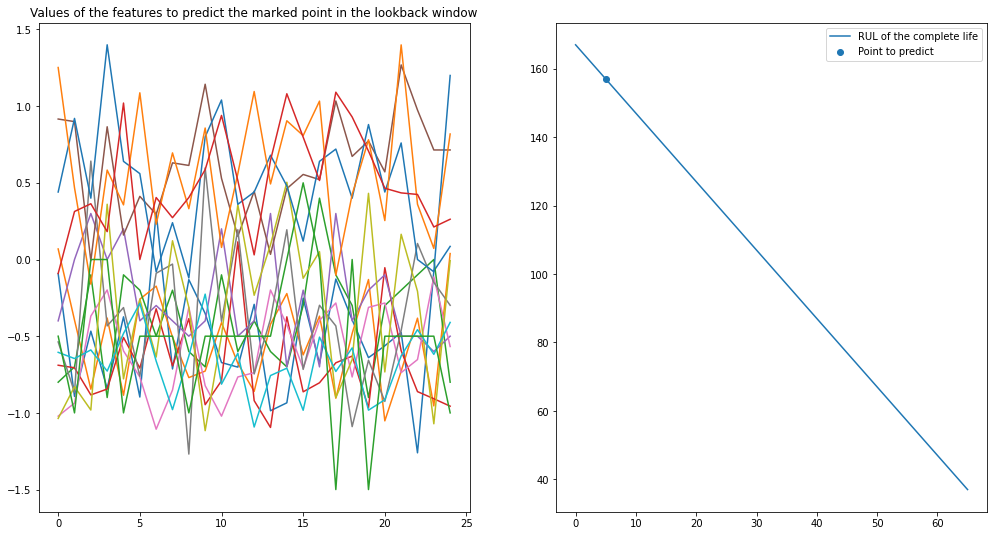

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[5, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(np.squeeze(y), label='RUL of the complete life')
ax[1].scatter(x=5, y=y[5], label='Point to predict')
ax[1].legend()

# Model

Let's create a simple model in keras with a same dense layers. The TrainableModel creates the batchers for the trainign and validation set and fit the models.

In [16]:
transformer = Transformer('RUL', 
                  transformerX=transformation_pipeline(
                      numericals_pipeline(
                          numerical_features=[
                              'T24', 'T30', 'T50'
                               'P15','P30','Nf','Nc', 'Ps30',
                               'phi', 'NRf', 'NRc', 'BPR', 
                               'htBleed', 'W31', 'W32'
                          ],
                          min_null_proportion=None,
                          outlier=IQROutlierRemover(1.5, 1), 
                          imputer=Pipeline(steps=[
                              ('ffill', ForwardFillImputer()),
                              ('mean', PandasMeanImputer())
                          ]),
                          scaler=PandasTransformerWrapper(MinMaxScaler((-1, 1))),
                      )))
model = FCN([100, 100],
            dropout=0.2,
            learning_rate=0.001,
            l2=0.2,
            window=15,
            batch_size = 8,
            step = 64,
            transformer = transformer,
            shuffle='signal',
            models_path='.',
            patience=7)

r = model.fit(train_dataset, validation_dataset , epochs=50, verbose=1)


(15, 13)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 195)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               19600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)      


Epoch 1/50
44/44 [==============================] - 5s 99ms/step - loss: 17480.1021 - root_mean_squared_error: 112.5886 - val_loss: 14036.1807 - val_root_mean_squared_error: 99.3552
Epoch 2/50
44/44 [==============================] - 4s 85ms/step - loss: 16309.0853 - root_mean_squared_error: 108.9606 - val_loss: 12991.4639 - val_root_mean_squared_error: 95.7243
Epoch 3/50
44/44 [==============================] - 4s 86ms/step - loss: 15379.8314 - root_mean_squared_error: 105.9325 - val_loss: 11931.5703 - val_root_mean_squared_error: 91.8129
Epoch 4/50
44/44 [==============================] - 4s 88ms/step - loss: 14197.5258 - root_mean_squared_error: 101.9119 - val_loss: 10882.5986 - val_root_mean_squared_error: 87.6722
Epoch 5/50
44/44 [==============================] - 4s 89ms/step - loss: 12954.0727 - root_mean_squared_error: 97.6057 - val_loss: 9759.9512 - val_root_mean_squared_error: 82.8498
Epoch 6/50
44/44 [==============================] - 4s 89ms/step - loss: 11617.8273 - root_

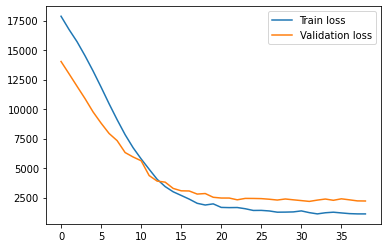

In [17]:
fig, ax = plt.subplots()
ax.plot(r['train_loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.legend()

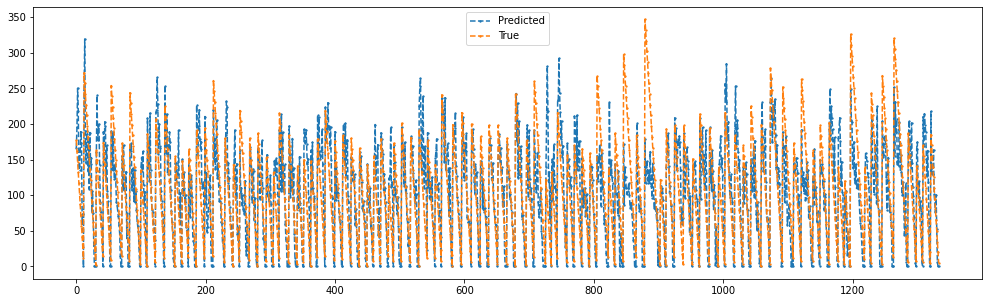

In [21]:
model.load_best_model()
y_pred = model.predict(validation_dataset, step=15)
y_true = model.true_values(validation_dataset, step=15)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(np.squeeze(y_pred), 'o--', label='Predicted', markersize=1.3)
ax.plot(np.squeeze(y_true), 'o--', label='True', markersize=1.3)
ax.legend()

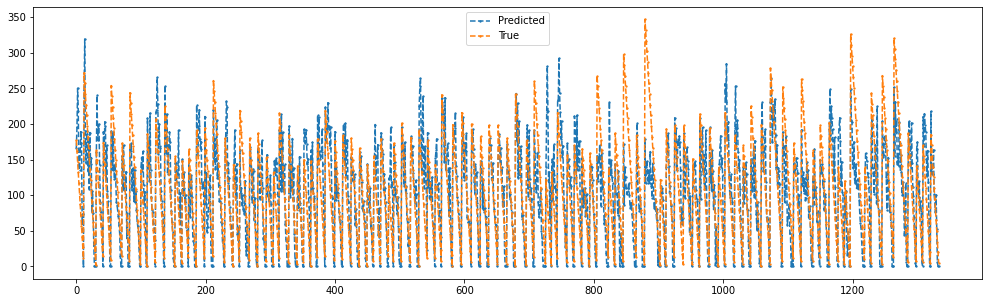

In [23]:
model.load_best_model()
y_pred = model.predict(validation_dataset, step=15)
y_true = model.true_values(validation_dataset, step=15)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(np.squeeze(y_pred), 'o--', label='Predicted', markersize=1.3)
ax.plot(np.squeeze(y_true), 'o--', label='True', markersize=1.3)
ax.legend()

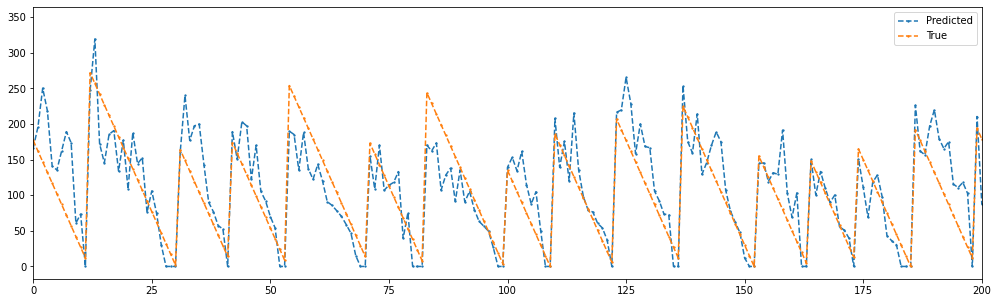

In [24]:
model.load_best_model()
y_pred = model.predict(validation_dataset, step=15)
y_true = model.true_values(validation_dataset, step=15)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(np.squeeze(y_pred), 'o--', label='Predicted', markersize=1.3)
ax.plot(np.squeeze(y_true), 'o--', label='True', markersize=1.3)
ax.set_xlim(0, 200)
ax.legend()